## Max Barshay

The main goal of this EDA is to get a feel for how the data is structured as well as to get a feel for the values of the data and how they are distributed. No machine learning models will be fit here, but the results found from some of these investigations will be used to advise the potential models that I will be fitting in the future.

In [220]:
from bs4 import BeautifulSoup
import json
import pandas as pd
import sklearn
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

pd.options.display.max_rows = 40

# Reading in the Data

Notice that I am reading in 10,000 lines of the training data set (there are many many more than that) and the entire test data set which is not that long.

In [221]:
train_10000 = open("/Users/mdbarshay/Desktop/DATA 301 Project/tensorflow2-question-answering/simplified-nq-train.jsonl")
records_train = []
c=0
for line in train_10000:
    records_train.append(json.loads(line))
    if c > 9999:
        break
    c+=1
train_frame = pd.DataFrame(records_train)
train_10000.close()

In [222]:
train_frame.columns
train_frame.head(3)

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852


In [223]:
test = open("/Users/mdbarshay/Desktop/DATA 301 Project/tensorflow2-question-answering/simplified-nq-test.jsonl")
records_test = []
for line in test:
    records_test.append(json.loads(line))
test_frame = pd.DataFrame(records_test)
test.close()

In [224]:
train_frame.head(3)

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852


In [225]:
test_frame.head(3)

,example_id,question_text,document_text,long_answer_candidates
0,-1220107454853145579,who is the south african high commissioner in ...,"High Commission of South Africa , London - wik...","[{'end_token': 136, 'start_token': 18, 'top_le..."
1,8777415633185303067,the office episode when they sing to michael,Michael 's Last Dundies - wikipedia <H1> Micha...,"[{'end_token': 190, 'start_token': 23, 'top_le..."
2,4640548859154538040,what is the main idea of the cross of gold speech,Cross of gold speech - wikipedia <H1> Cross of...,"[{'end_token': 165, 'start_token': 12, 'top_le..."


# Feature Exploration

At this point I am exploring the features of the different data sets to try to get a feel for the differences in the test and training sets and to try to get familiar with how the data is structured.

I start with just exploring the data and seeing what the various fields look like.

It appears that the test data has 346 rows and 4 columns, while the training set has 10001 rows (I told it to) and 6 columns.

In [226]:
print(test_frame.shape)
print(train_frame.shape)

(346, 4)
(10001, 6)


This following is an example of some typical text within the document text field of the test set. We can clearly see there are many non-alpha numeric characters here as well as many HTML tags, that according to the page for the competition "are there to help provide structure" they also said that many tags that were not neccesary were removed.

In [227]:
first_test_text = test_frame.iloc[0,2]
first_test_text[:1000]

'High Commission of South Africa , London - wikipedia <H1> High Commission of South Africa , London </H1> <Table> <Tr> <Th_colspan="2"> High Commission of South Africa in London </Th> </Tr> <Tr> <Td_colspan="2"> </Td> </Tr> <Tr> <Th> Location </Th> <Td> Trafalgar Square , London </Td> </Tr> <Tr> <Th> Address </Th> <Td> Trafalgar Square , London , WC2N 5DP </Td> </Tr> <Tr> <Th> Coordinates </Th> <Td> 51 ° 30 ′ 30 \'\' N 0 ° 07 ′ 37 \'\' W \ufeff / \ufeff 51.5082 ° N 0.1269 ° W \ufeff / 51.5082 ; - 0.1269 Coordinates : 51 ° 30 ′ 30 \'\' N 0 ° 07 ′ 37 \'\' W \ufeff / \ufeff 51.5082 ° N 0.1269 ° W \ufeff / 51.5082 ; - 0.1269 </Td> </Tr> <Tr> <Th> High Commissioner </Th> <Td> Vacant </Td> </Tr> </Table> Balcony of South Africa House <P> The High Commission of South Africa in London is the diplomatic mission from South Africa to the United Kingdom . It is located at South Africa House , a building on Trafalgar Square , London . As well as containing the offices of the High Commissioner , the

This is what a typical set of possible answers look like. They give us a start and an end token which correspond to the tokens (including HTML) for which you can index into the split document text to extract. Once you call .split(" ") on the document text you can get the first potential answer by slicing the resulting list like such: [14:170] for example.

Notice that here I am going back to the training set. The format of both the training and test sets are quite similar with the main difference being the fact that the training set contains the correct answer (both long and short). During this EDA I might go back and forth between the test and training sets interchangebly since they contain much of the same data.

In [228]:
candidates = train_frame.iloc[:,1]
candidates.iloc[0] #hopefully this is not too long of a printout, I think it is needed to get the point across about
# the structure of the long answer candidates

[{'start_token': 14, 'top_level': True, 'end_token': 170},
 {'start_token': 15, 'top_level': False, 'end_token': 169},
 {'start_token': 52, 'top_level': False, 'end_token': 103},
 {'start_token': 53, 'top_level': False, 'end_token': 102},
 {'start_token': 103, 'top_level': False, 'end_token': 156},
 {'start_token': 104, 'top_level': False, 'end_token': 155},
 {'start_token': 170, 'top_level': True, 'end_token': 321},
 {'start_token': 171, 'top_level': False, 'end_token': 180},
 {'start_token': 180, 'top_level': False, 'end_token': 186},
 {'start_token': 186, 'top_level': False, 'end_token': 224},
 {'start_token': 188, 'top_level': False, 'end_token': 222},
 {'start_token': 189, 'top_level': False, 'end_token': 194},
 {'start_token': 194, 'top_level': False, 'end_token': 200},
 {'start_token': 200, 'top_level': False, 'end_token': 205},
 {'start_token': 224, 'top_level': False, 'end_token': 231},
 {'start_token': 231, 'top_level': False, 'end_token': 257},
 {'start_token': 233, 'top_lev

Top level refers to whether or not other questions are nested within the original top level question. So, for example the first observation in this list of dictionaries corresponds to start token: 14 and end token: 170 and its top level is set to true. The next observation is nested inside of that so its top level is false.

I will now look at the fourth observation because I like football and I wanted to display how splitting on white space and indexing works.

In [229]:
fourth = train_frame.iloc[3]# here we are extracting the fourth observation

In [230]:
fourth # this is a series containing all of the information that comes with a TRAINING set observation
# notice the annotations which contains a dictionary of the correct answer as well as 

document_text             List of National Football League career quarte...
long_answer_candidates    [{'start_token': 28, 'top_level': True, 'end_t...
question_text                              who had the most wins in the nfl
annotations               [{'yes_no_answer': 'NONE', 'long_answer': {'st...
document_url              https://en.wikipedia.org//w/index.php?title=Li...
example_id                                              5289242154789678439
Name: 3, dtype: object

In [231]:
fourthT = test_frame.iloc[3] # fourth observation of test set for contrast
fourthT 

example_id                                             -5316095317154496261
question_text                      when was i want to sing in opera written
document_text             Wilkie Bard - wikipedia <H1> Wilkie Bard </H1>...
long_answer_candidates    [{'end_token': 105, 'start_token': 8, 'top_lev...
Name: 3, dtype: object

I quickly printed the fourth test set observation out just to illustrate that the test set is similar to the training set with the only difference being that the observations in the test set do not contain annotations and they do not contain the document url. The first makes sense to me, we cannot have the labels in our test set, but the fact that the document URL is ommitted is somewhat of a mystery to me, however it will not make much of a difference in the end.

Let us now get back to the topic at hand and continue with our NFL example.

In [232]:
fourth.question_text # here is the fourth question

'who had the most wins in the nfl'

In [233]:
fourth.document_url # here is the url of the question. Notice how the (relevant) title is included in the URL

'https://en.wikipedia.org//w/index.php?title=List_of_National_Football_League_career_quarterback_wins_leaders&amp;oldid=818143757'

I now display the annotations for this training set observation. Notice that it contains information on whether the question had a yes-no answer, the correct long answer tokens for indexing, the candidate index, meaning what index of the list of possible candidates the correct answer occured, the tokens for the short answer (if applicable), as well as an annotation ID which is unique from the id for the observation itself.

In [234]:
fourth.annotations

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 509, 'candidate_index': 59, 'end_token': 576},
  'short_answers': [{'start_token': 512, 'end_token': 514}],
  'annotation_id': 14634796365152556576}]

I am now tokenizing the text by splitting it using pythons .split() which has a default to split on white space.

In [235]:
fourth_tokenized = fourth.document_text.split()
fourth_tokenized[:30] #only print out the first 30 tokens

['List',
 'of',
 'National',
 'Football',
 'League',
 'career',
 'quarterback',
 'wins',
 'leaders',
 '-',
 'wikipedia',
 '<H1>',
 'List',
 'of',
 'National',
 'Football',
 'League',
 'career',
 'quarterback',
 'wins',
 'leaders',
 '</H1>',
 'Jump',
 'to',
 ':',
 'navigation',
 ',',
 'search',
 '<Table>',
 '<Tr>']

This is the correct long answer to the question:

In [236]:
" ".join(fourth_tokenized[509:576]) # I join it so that it prints out more nicely.
# Notice how it begins on ends on <P> and </P> I would guess that this is quite common given most 
# answers were likely found inside of a paragraph.

"<P> Active quarterback Tom Brady holds the records for most wins with 220 , most regular season wins with 195 , and most postseason wins with 25 , as of Week 16 of the 2017 NFL season . Having played the entirety of his career with the New England Patriots , each of Brady 's win records also apply to wins with a single team . </P>"

This is the short answer:

In [237]:
" ".join(fourth_tokenized[512:514])

'Tom Brady'

In [238]:
"There were " + str(len(fourth.long_answer_candidates)) + " possible answers to choose from for the fourth question."

'There were 481 possible answers to choose from for the fourth question.'

That is quite a lot! Upon further evauation (that I ended up editing out because it is somewhat mundane) it appears that almost all of the paragraphs in the document are included as possible answers.

This gives me a decent idea of the various fields in the data set, I can now move on to some preliminary analysis.

# Quantitative Analysis and Graphs

I now move on to exploring the numbers and trying to dig a little big deeper into the analytics of the data.

I start with seeing what the how many words the average question contained.

In [239]:
question_length = []
for i in range(len(train_frame)):
    question_length.append(len((train_frame.loc[i, "question_text"]).split()))

In [240]:
pd.Series(question_length).value_counts() #value counts saving the day once again

8     4428
9     2386
10    1218
11     690
12     368
7      248
13     246
14     169
15     103
16      70
17      35
18      14
6       13
19      10
20       2
21       1
dtype: int64

Here is a bar chart representing the distribution of word lengths across the various questions.

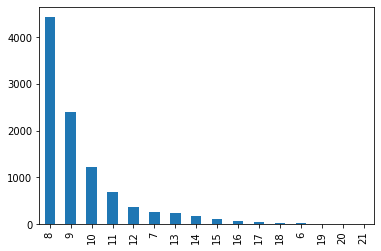

In [241]:
pd.Series(question_length).value_counts().plot.bar()

It looks like the most common length of question was 8 words. Also there was a fair amount of questions that were 9 and 10 words. There are also some words that are greater than 20 words in length, these are questions that I may have to consider getting rid of as they may potentially interfere with some of the machine learning models that I plan to fit in the future.

In [242]:
pd.Series(question_length).mean()

9.221577842215778

The mean length of question that was asked was 9.2216 words. 

# Answer Exploration

I will now see what the average length of a long answer question was, similar to how I checked for the question lengths. Notice for this I am just subtracting the tokens rather than indexing in and calculating the length. I believe that this is faster as well as easier.

In [243]:
annotations_train = train_frame.annotations

In [244]:
long_answer_lengths = []
for data in annotations_train:
    long_answer_lengths.append((data[0]["long_answer"]["end_token"] - data[0]["long_answer"]["start_token"]))

In [245]:
LA_lengths = pd.Series(long_answer_lengths)

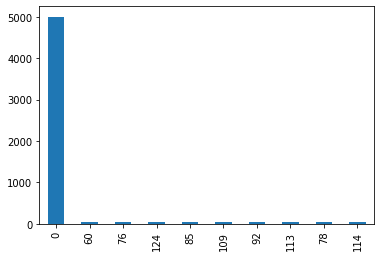

In [246]:
LA_lengths.value_counts().head(10).plot.bar()

Unsurpringly we see that 0 was the most common possible answer, trumping the next most common of 60, 76, and 124. I chose to keep this somewhat uninformative bar chart in to remind the reader that 0 was by **far** the most common length and that we really lose half of the observations in our analysis to those that do not have a potential long answer.

In [247]:
LA_lengths.mean()

184.16288371162884

It appears that on average, including tags and answers that had no long answer, the average long answer length was 184.16 tokens long. If there was a long answer that did not have a yes/no answer then its tokens were -1 and -1 for start and end respectively and that would add a 0 for that repitition for the mean calculation. Taking this into account the average length for long answers that **did** exist was greater than 184.

I will now check the ratio, of the first 10,000 observations, in which there was a yes/no answer using a similar looping strategy as before.

In [248]:
yes_no_rate = []
for entry in annotations_train:
    if entry[0]["yes_no_answer"] == "NONE":
        yes_no_rate.append("None")
    else:
        yes_no_rate.append("Not None")

In [249]:
pd.Series(yes_no_rate).value_counts()

None        9879
Not None     122
dtype: int64

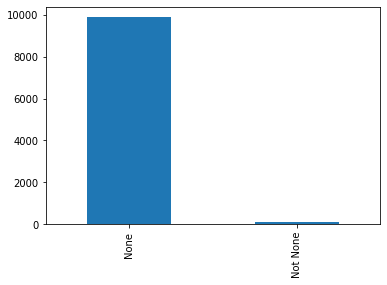

In [250]:
pd.Series(yes_no_rate).value_counts().plot.bar()

It appears that actually 122 of the first 10,000 observations had short answers that were not NONE. This graph further illustrates the stark difference in counts between these two groups. There is a small and almost negligible proportion of answers the actually contained a yes/no answer. Now I will check the distribution of yeses and nos within the answers that were possible to answer with a yes or a no.

In [251]:
yes_no_rate = []
for entry in annotations_train:
    if entry[0]["yes_no_answer"] == "NONE":
        continue
    elif entry[0]["yes_no_answer"] == "YES":
        yes_no_rate.append("Yes")
    elif entry[0]["yes_no_answer"] == "NO":
        yes_no_rate.append("No")
    else:
        yes_no_rate.append("Other")

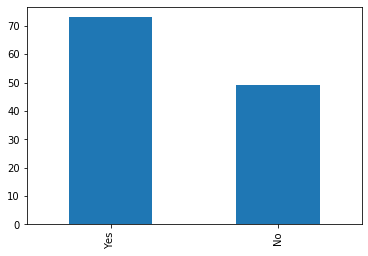

In [252]:
pd.Series(yes_no_rate).value_counts().plot.bar()

In [253]:
pd.Series(yes_no_rate).value_counts()

Yes    73
No     49
dtype: int64

We can see that there were 73 yes answers of the yes/no's, and there were 49 no's out of all the yes/no's. Luckily there were no other values such as missing values that we would have to throw away. I wouldn't say this is an easy data set to work with but they spared us in that department.

Now, I will look at the target data and try to determine which words were the most common in the correct long answer responses of our training data.

I will do this by first looping through the training data frame and extracting the start and end indices and putting those into a data frame.

In [254]:
starting_index = []
ending_index = []
for i in range(len(train_frame)):
    starting_index.append((train_frame.iloc[i]["annotations"][0]["long_answer"]["start_token"]))
    ending_index.append((train_frame.iloc[i]["annotations"][0]["long_answer"]["end_token"]))

In [255]:
index_frame = pd.DataFrame({"start_token": starting_index, "end_token": ending_index})
# using the dictionary method for creating a data frame

In [256]:
index_frame_not_null = index_frame[index_frame["start_token"] != -1] # I am getting rid of any questions that
# had no long answer
index_frame_not_null

,start_token,end_token
0,1952,2019
1,212,310
2,319,438
3,509,576
6,82,169
...,...,...
9990,181,200
9991,267,317
9992,118,182
9993,108,128


Extremely surprisingly, we see that 5,000 of the first 10,001 observations had a start index of -1, which for this data set means that there was no reasonable correct answer to the question that they were able to come up with. The surprising part is really that (virtually) EXACTLY half of the observations did not have a long answer out of the first 10,000 observations of the test data. I am not sure if this is by design or a random coincidence. Either way, now I am going to index into the dataframe to extract the text corresponding to all of the correct long answers.

In [257]:
words = []
for i in range(10000):
    if index_frame.iloc[i,0] != -1: #removing the non-existent long answers to stay consistent
        words.append(train_frame["document_text"][i].lower().split()[index_frame.iloc[i,0]:index_frame.iloc[i,1]])

This shows that my code above worked and also illustrates the fact that not all answers come between the paragraph HTML symbols.

In [258]:
series_of_words = pd.Series(words)
series_of_words

0       [<p>, a, common, example, of, permission, mark...
1       [<p>, tracy, mcconnell, ,, better, known, as, ...
2       [<p>, the, process, of, fertilization, involve...
3       [<p>, active, quarterback, tom, brady, holds, ...
4       [<p>, pom, klementieff, (, born, 3, may, 1986,...
                              ...                        
4995    [<li>, south, dakota, 's, at, -, large, distri...
4996    [<p>, ``, we, built, this, city, '', is, a, 19...
4997    [<p>, a, ham, and, cheese, sandwich, is, a, co...
4998    [<tr>, <th>, original, air, date, </th>, <td>,...
4999    [<p>, commenting, on, the, band, 's, recording...
Length: 5000, dtype: object

Printing out the words that I just created we see that they are in the format of lists of lists, where each sublist corresponds to a question. I will now make them all into one list so that processing is easier.

In [260]:
big_list = []
for sublist in words:
    for word in sublist:
        big_list.append(word)

In [261]:
"We have " + str(len(big_list)) + " words in this list containing words from all of the document texts."

'We have 1841813 words in this list containing words from all of the document texts.'

It appears as though it worked! We can now use the Counter object to get the word counts (another option would be to use a count vectorizer).

In [262]:
counts = Counter(big_list)

I believe that the easiest way to search through this large Counter object is to just extract the most common words. But alas, we have a problem most of the most common words are HTML tags.

In [263]:
counts.most_common(20)

[('</td>', 198860),
 ('<td>', 193576),
 (',', 60623),
 ('the', 45363),
 ('<tr>', 40554),
 ('</tr>', 40554),
 ('.', 32164),
 (')', 22706),
 ('(', 22685),
 ('and', 21952),
 ('of', 20865),
 ('-', 20321),
 ('to', 17457),
 ('in', 16070),
 ('</th>', 15224),
 ('a', 14761),
 ('--', 14262),
 ('<th>', 13774),
 ('<li>', 9692),
 ('</li>', 9692)]

It appears as though there is going to be a lot of pre-processing that has to be done before this data can be easily used to make predictions. It appears as though regular expressions could be used.

I decided to make a long string of things to remove, although there are many different ways to do this.

I am looping through and removing all words that are in the removables string.

In [264]:
removables = ";,./?><()*^%$#@!</td><td><tr></tr>-<th></th>''--``<p></p>°\ufeff♠'<li></li>'s:<td_colspan=\"2\"> \
<ul></ul><table></table><th_colspan=\"2\">"
big_list_filtered = []
for word in big_list:
    if word not in removables:
        big_list_filtered.append(word)
        
most_common_100 = Counter(big_list_filtered).most_common(100)

Now I have saved the most common 100 words into a list called most_common_100 I am going to now process this list into a dataframe so that it is nicer to view.

In [265]:
words = []
counts = []
for item in most_common_100: #processing before data frame creation
    words.append(item[0])
    counts.append(item[1])

In [266]:
frequency_df = pd.DataFrame({"word": words, "count": counts}) #creating data frame

In [267]:
frequency_df.set_index("word", inplace = True) #setting the index to word

Now I am plotting the top 15 words by their frequency and it is much of what you would expect. The top three words are the, and, (as well as) of. I didn't want to say and again.

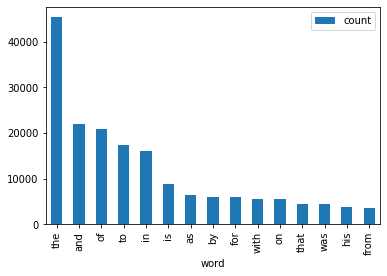

In [268]:
frequency_df.head(15).plot.bar()

This bar chart seems very reasonable as I would have guessed that the word "the" would be the most commonly used word. The fact that my assumption of the most common words was correct suggests that a tf-idf vectorizer may have better performance for predicting than just a regular count vectorizer since a count vectorizer is likely to give too much weight to these common and less meaningful words that are shown above.

Now, I will attempt to discover whether or not there is an association with questions and their answers.

# Question Exploration

Lets take a quick look at the format that the questions are in just to refresh our memory. We have a series of questions.

In [269]:
train_frame.question_text.head()

0    which is the most common use of opt-in e-mail ...
1              how i.met your mother who is the mother
2     what type of fertilisation takes place in humans
3                     who had the most wins in the nfl
4      what happened to the lost settlement of roanoke
Name: question_text, dtype: object

I am going to get all of the words from the questions into one large list.

In [270]:
question_words = []
for word in train_frame.question_text: # This is an intermediate step where I am getting a list of lists
    question_words.append(word.split())

In [271]:
mega_word = []
for sublist in question_words: # this is where I am actually generating the large list of all the words
    for word in sublist:
        mega_word.append(word)

The following code extracts the 20 most common words.

In [272]:
question_counts = Counter(mega_word).most_common(20)

In [273]:
question_counts

[('the', 8506),
 ('of', 3778),
 ('in', 3402),
 ('who', 2624),
 ('is', 2277),
 ('what', 1676),
 ('when', 1391),
 ('a', 1296),
 ('to', 1170),
 ('and', 1086),
 ('where', 1061),
 ('did', 1025),
 ('was', 939),
 ('does', 858),
 ('on', 844),
 ('how', 715),
 ('are', 601),
 ('for', 573),
 ('from', 530),
 ('come', 472)]

I now get my words into a data frame once again so that I can easily plot the distribution of most common words.

In [274]:
words = [] 
counts = []
for item in question_counts:
    words.append(item[0])
    counts.append(item[1])

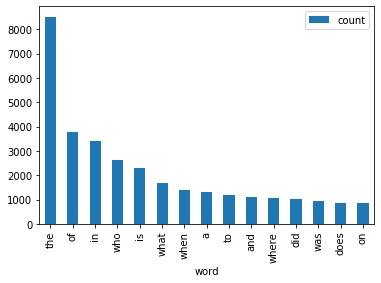

In [275]:
frequency_df = pd.DataFrame({"word": words, "count": counts})
frequency_df.set_index("word", inplace = True)
frequency_df.head(15).plot.bar()

We get a similar distribution here as well. Showing that a tf-idf vectorizer would likely be beneficial on both the questions and the long answers. We only checked the correct long answers, but I think that many of the incorrect long answers would likely contain many of the same common words.

# TF-IDF Exploration

We just saw what the most common words were in both the question and the correct long answers. Let me now try to determine what the most *meaningful* word is in both the questions and the document correct answers. It likely is not the most common word or else the tf-idf would be out of business.

I will pull up the series of correct answers that I have from before where each observation in the series corresponds to a correct answer.

In [276]:
series_of_words = series_of_words.apply(lambda x : " ".join(x))

In [277]:
series_of_words # I just made a quick formatting change to get it ready to be vectorized.

0       <p> a common example of permission marketing i...
1       <p> tracy mcconnell , better known as `` the m...
2       <p> the process of fertilization involves a sp...
3       <p> active quarterback tom brady holds the rec...
4       <p> pom klementieff ( born 3 may 1986 ) is a f...
                              ...                        
4995    <li> south dakota 's at - large district : kri...
4996    <p> `` we built this city '' is a 1985 song wr...
4997    <p> a ham and cheese sandwich is a common type...
4998    <tr> <th> original air date </th> <td> may 6 ,...
4999    <p> commenting on the band 's recording of `` ...
Length: 5000, dtype: object

I will now create a TfidfVectorizer and fit it on the series of words shown above. First, I create the vectorizer, then fit it on the series of words where each answer represents a document, then I transform the series and turn it into a pandas dataframe for ease of analysis. I use english as stop words here, just because it could potentially improve results.

In [278]:
tfidf = TfidfVectorizer("english")

In [279]:
tfidf.fit(series_of_words)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='english', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [280]:
word_matrices = tfidf.transform(series_of_words)

In [281]:
word_matrices = pd.DataFrame.sparse.from_spmatrix(word_matrices)

Each column of this data frame represents a word and each row represents one of the 5000 non empty questions.

In [282]:
word_matrices

,0,1,2,3,4,5,6,7,8,9,...,66447,66448,66449,66450,66451,66452,66453,66454,66455,66456
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [283]:
idf = tfidf.idf_

In [284]:
words_tfidfs = dict(zip(tfidf.get_feature_names(), idf))

In [285]:
ordered_dict = {k: v for k, v in sorted(words_tfidfs.items(), key=lambda item: item[1], reverse = True)}

We clearly have a problem here, we see that all of the words with the highest tf-idf score are all long numbers that likely only occurred once and add pretty much no practical meaning to the answer. I believe that getting rid of these would improve prediction accuracy.

In [286]:
dict(list(ordered_dict.items())[0:30])

{'00000': 8.824245990858959,
 '0000000000000000000': 8.824245990858959,
 '000000000100': 8.824245990858959,
 '000000000117': 8.824245990858959,
 '000000000280': 8.824245990858959,
 '000000000400': 8.824245990858959,
 '000000000441': 8.824245990858959,
 '000000000470': 8.824245990858959,
 '000000000550': 8.824245990858959,
 '000000000557': 8.824245990858959,
 '000000000589': 8.824245990858959,
 '000000000624': 8.824245990858959,
 '000000000630': 8.824245990858959,
 '000000000655': 8.824245990858959,
 '000000000715': 8.824245990858959,
 '000000000720': 8.824245990858959,
 '000000000750': 8.824245990858959,
 '000000000800': 8.824245990858959,
 '000000000850': 8.824245990858959,
 '000000000969': 8.824245990858959,
 '000000000980': 8.824245990858959,
 '000000001029': 8.824245990858959,
 '000000001080': 8.824245990858959,
 '000000001218': 8.824245990858959,
 '000000001270': 8.824245990858959,
 '000000001309': 8.824245990858959,
 '000000001310': 8.824245990858959,
 '000000001312': 8.824245990

In [287]:
res = []
for i in range(len(series_of_words)):
    sublist = []
    temp = series_of_words[i].split()
    for word in temp:
        if not word.isdigit() and not word.isnumeric():
            sublist.append(word)
    res.append(sublist)

In [288]:
series_of_words = pd.Series(res)
series_of_words = series_of_words.apply(lambda x : " ".join(x))

In [289]:
tfidf = TfidfVectorizer(stop_words = "english") # I attempted to use this parameter to improve the results
tfidf.fit(series_of_words)
word_matrices = tfidf.transform(series_of_words)
word_matrices = pd.DataFrame.sparse.from_spmatrix(word_matrices)
idf = tfidf.idf_
words_tfidfs = dict(zip(tfidf.get_feature_names(), idf))
ordered_dict = {k: v for k, v in sorted(words_tfidfs.items(), key=lambda item: item[1], reverse = True)}
dict(list(ordered_dict.items())[0:30])

{'0000': 8.824245990858959,
 '00001': 8.824245990858959,
 '000179': 8.824245990858959,
 '0002': 8.824245990858959,
 '0003': 8.824245990858959,
 '0004': 8.824245990858959,
 '000524': 8.824245990858959,
 '0006': 8.824245990858959,
 '0007': 8.824245990858959,
 '0008': 8.824245990858959,
 '0009': 8.824245990858959,
 '0011': 8.824245990858959,
 '0012': 8.824245990858959,
 '0014': 8.824245990858959,
 '0016': 8.824245990858959,
 '0018': 8.824245990858959,
 '001818': 8.824245990858959,
 '00218': 8.824245990858959,
 '0025': 8.824245990858959,
 '0030': 8.824245990858959,
 '0031': 8.824245990858959,
 '0068': 8.824245990858959,
 '0069': 8.824245990858959,
 '0070': 8.824245990858959,
 '00787': 8.824245990858959,
 '0085': 8.824245990858959,
 '008c45': 8.824245990858959,
 '0093': 8.824245990858959,
 '0094': 8.824245990858959,
 '00am': 8.824245990858959}

For some reason the code above does not work quite as I had hoped that it would. Regardless I think that it will not make much of a difference in my results, given that they are quite rare words and who knows maybe seeing a long number like that will hint the classifier that that is not a correct answer.

A somewhat interesting thing to note though, upon looking at these numbers is the 8.824245990858959 seems to be the highest that an inverse document frequency weight can go up to. I wonder if this number has some special meaning.